# Getting Started with ESG Document Classifier

This notebook is mainly to reduce the friction on getting started with the competition. Obviously, it's not state of the art. It performs slightly worse than the baseline but it should be enough to get you started. 

This covers basically from start to finish incluidng:
- Viewing/extracting content from PDF
- Vectorizing the content
- Run a classification using SVM
- Output the submission file

Feel free to clone and improve upon it with your very own awesome models. Enjoy!!!

In [1]:
!pip install -U pypdfium2 wordcloud

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
from wordcloud import WordCloud
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pypdfium2 as pdfium

%matplotlib inline

# Helper Functions

In [3]:
def get_pdf(path):
    return pdfium.PdfDocument(path)

def get_content(page):
    textpage = page.get_textpage()
    return textpage.get_text_range()

def render(page):
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

def extract_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename)
    pdf = get_pdf(filepath)
    page = pdf[page_num]
    content = get_content(page)

    content = " ".join(content.lower().split())
    return content

# Read a page of a PDF

In [4]:
filepath = './oxml2023mlcases-esg-classifier/data/reports/report_1012.pdf'

pdf = get_pdf(filepath)
page = pdf[17]
content = get_content(page)

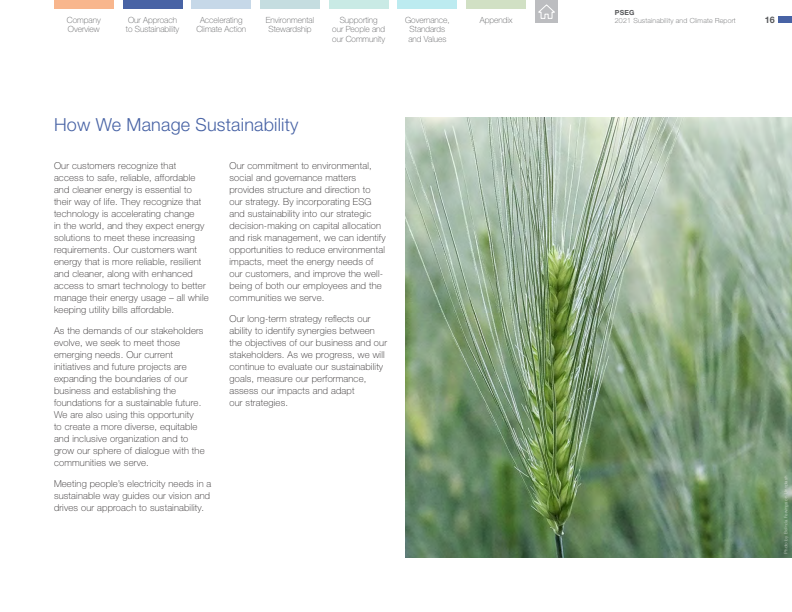

In [5]:
render(page)

In [6]:
print(content)

PSEG
Company 2021 Sustainability and Climate Report 16
Overview
Our Approach 
to Sustainability
Accelerating 
Climate Action
Environmental
Stewardship
Supporting 
our People and 
our Community
Governance, 
Standards 
and Values
Appendix
Our customers recognize that 
access to safe, reliable, affordable 
and cleaner energy is essential to 
their way of life. They recognize that 
technology is accelerating change 
in the world, and they expect energy 
solutions to meet these increasing 
requirements. Our customers want 
energy that is more reliable, resilient 
and cleaner, along with enhanced 
access to smart technology to better 
manage their energy usage – all while 
keeping utility bills affordable. 
As the demands of our stakeholders 
evolve, we seek to meet those 
emerging needs. Our current 
initiatives and future projects are 
expanding the boundaries of our 
business and establishing the 
foundations for a sustainable future. 
We are also using this opportunity 
to create a more 

# Load Data

In [7]:
basepath = "./oxml2023mlcases-esg-classifier/data/"
report_path = os.path.join(basepath, "reports")
label_path = os.path.join(basepath, "labels.csv")

In [8]:
df = pd.read_csv(label_path)

df.head()

id       class
0    report_519.pdf.53  governance
1   report_1537.pdf.24      social
2    report_567.pdf.33  governance
3  report_1830.pdf.220       other
4   report_1253.pdf.46  governance

In [9]:
contents = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_id = row['id']
    content = extract_content_from_id(file_id)
    contents.append(content)
    
df['content'] = contents

  0%|          | 0/1956 [00:00<?, ?it/s]

In [10]:
df.head()

id       class  \
0    report_519.pdf.53  governance   
1   report_1537.pdf.24      social   
2    report_567.pdf.33  governance   
3  report_1830.pdf.220       other   
4   report_1253.pdf.46  governance   

                                             content  
0  2021 esg impact report data privacy, security,...  
1  2021 sustainability report table of contents 2...  
2  sustainability governance clean harbors’ commi...  
3  220 report of the réviseur d’entreprises agréé...  
4  46 pfizer 2021 esg report governance governanc...

# Basic Data Analysis

In [11]:
# Preprocessing and tokenize each page
all_tokens = []
page_len = []
for x in df['content']:
    tokens = x.split()
    page_len.append(len(tokens))
    all_tokens += tokens

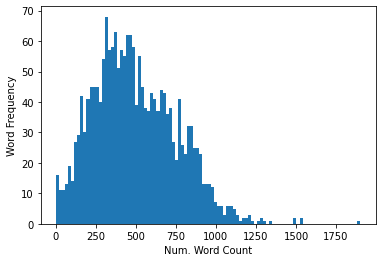

In [12]:
# Let's check frequency for the word count for each page
plt.hist(page_len, bins=100)
plt.xlabel('Num. Word Count')
plt.ylabel('Word Frequency')
plt.show()

Majority of the page centers around 250 to 750 words. Its right tail goes up to almost 2,000 words. However, there are only a few pages that contain that many words. 

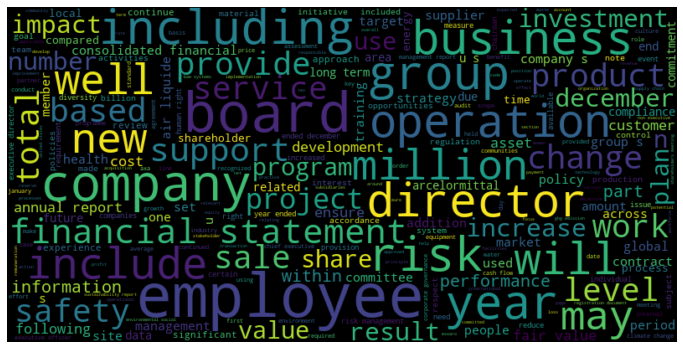

In [13]:
wordcloud = WordCloud(max_words=250, max_font_size=72, width=800, height=400).generate(" ".join(all_tokens))

plt.figure(figsize=(12, 18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Simple Machine Learning with TF-IDF

In [14]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
# Encode the label classes
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
print(label_encoder.classes_)

['environmental' 'governance' 'other' 'social']


In [16]:
(df['class'].nunique())

4

In [17]:
df.head()

id       class  \
0    report_519.pdf.53  governance   
1   report_1537.pdf.24      social   
2    report_567.pdf.33  governance   
3  report_1830.pdf.220       other   
4   report_1253.pdf.46  governance   

                                             content  label  
0  2021 esg impact report data privacy, security,...      1  
1  2021 sustainability report table of contents 2...      3  
2  sustainability governance clean harbors’ commi...      1  
3  220 report of the réviseur d’entreprises agréé...      2  
4  46 pfizer 2021 esg report governance governanc...      1

In [18]:
#remove stop words from content
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('english') + stopwords.words('french')
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['content_without_stopwords'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stopwords_list)]))

# tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
#   max_features=200000,
#   min_df=0.2,
#   stop_words=final_stopwords_list,
#   use_idf=True,
#   tokenizer=tokenize_and_stem,
#   ngram_range=(1,3))

In [19]:
# Split Train/Test set with 80:20
X_train, X_test, y_train, y_test = train_test_split(df['content_without_stopwords'], df['label'], test_size=.3)

In [20]:
# Use TF-IDF to vectorize each document
vectorizer = TfidfVectorizer(max_df=0.8,
  max_features=200000,
  min_df=0.2,
  stop_words=final_stopwords_list,
  use_idf=True,
  #tokenizer=tokenize_and_stem,
  ngram_range=(1,3))
X_train_features = vectorizer.fit_transform([x for x in X_train])
X_test_features = vectorizer.transform([x for x in X_test])

In [21]:
#svm

In [22]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)

In [23]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'accuracy: {acc}')
print(f'f1 score: {f1}')

accuracy: 0.8943781942078365
f1 score: 0.8664791974045554


In [24]:
#xgboost

In [25]:
# fit model no training data
#model = XGBClassifier()
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=4,
    nthread=4,
    scale_pos_wieght=1,
    seed=123)

xgb_cl.fit(X_train_features, y_train)
print(xgb_cl)


[18:35:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_wieght" } are not used.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_class=4,
              num_parallel_tree=None, ...)


In [26]:
# make predictions for test data
y_pred = xgb_cl.predict(X_test_features)
predictions = [round(value) for value in y_pred]

In [27]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.78%


In [28]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'accuracy: {acc}')
print(f'f1 score: {f1}')

accuracy: 0.8977853492333902
f1 score: 0.8630656258757561


In [42]:
#umap
#https://umap-learn.readthedocs.io/en/latest/document_embedding.html#using-tf-idf
%matplotlib inline

In [43]:
import pandas as pd
import umap
import umap.plot

# Used to get the data
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

In [44]:
vectorizer = CountVectorizer(min_df=10, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(df.content_without_stopwords)

In [45]:
word_doc_matrix


<1956x5467 sparse matrix of type '<class 'numpy.int64'>'
	with 311425 stored elements in Compressed Sparse Row format>

In [46]:
%%time
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

CPU times: user 15.6 s, sys: 389 ms, total: 16 s
Wall time: 9.39 s


In [47]:
embedding.embedding_.shape


(1956, 2)

In [48]:
df.head()

id       class  \
0    report_519.pdf.53  governance   
1   report_1537.pdf.24      social   
2    report_567.pdf.33  governance   
3  report_1830.pdf.220       other   
4   report_1253.pdf.46  governance   

                                             content  label  \
0  2021 esg impact report data privacy, security,...      1   
1  2021 sustainability report table of contents 2...      3   
2  sustainability governance clean harbors’ commi...      1   
3  220 report of the réviseur d’entreprises agréé...      2   
4  46 pfizer 2021 esg report governance governanc...      1   

                           content_without_stopwords  
0  2021 esg impact report data privacy, security,...  
1  2021 sustainability report table contents 24 s...  
2  sustainability governance clean harbors’ commi...  
3  220 report réviseur d’entreprises agréé • eval...  
4  46 pfizer 2021 esg report governance governanc...

In [49]:
%matplotlib inline

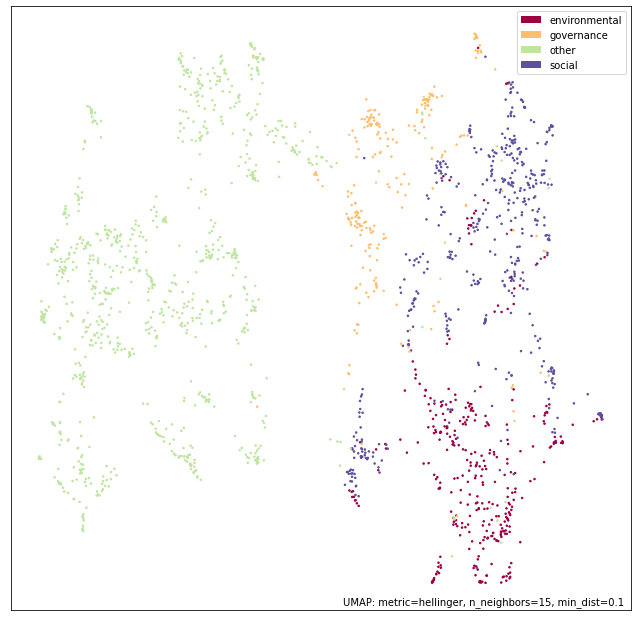

In [50]:
# For interactive plotting use
# f = umap.plot.interactive(embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(f)
f = umap.plot.points(embedding, labels=df['class'])

In [52]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(df.content_without_stopwords)

In [53]:
tfidf_word_doc_matrix

<1956x8116 sparse matrix of type '<class 'numpy.float64'>'
	with 328867 stored elements in Compressed Sparse Row format>

In [54]:
%%time
tfidf_embedding = umap.UMAP(metric='hellinger').fit(tfidf_word_doc_matrix)

CPU times: user 18.2 s, sys: 458 ms, total: 18.6 s
Wall time: 12.2 s


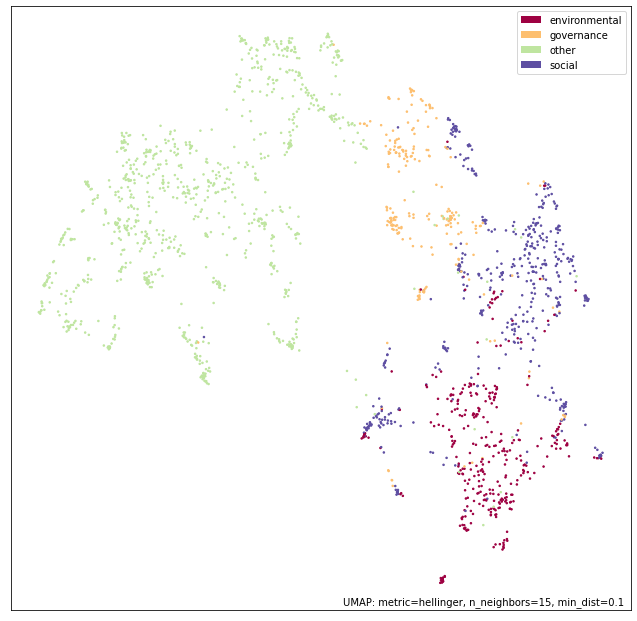

In [56]:
# For interactive plotting use
# fig = umap.plot.interactive(tfidf_embedding, labels=dataset.target, hover_data=hover_df, point_size=1)
# show(fig)
fig = umap.plot.points(tfidf_embedding, labels=df['class'])

In [51]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from umap import UMAP
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf2 = GridSearchCV(svc, params_grid)
clf2.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf2.score(X_test_features, y_test))
)

# Transformation with UMAP followed by classification with a linear SVM
umap = UMAP(random_state=456)
pipeline = Pipeline([("umap", umap), ("svc", svc)])
params_grid_pipeline = {
    "umap__n_neighbors": [5, 20],
    "umap__n_components": [15, 25, 50],
    "svc__C": [10 ** k for k in range(-3, 4)],
}


clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
clf_pipeline.fit(X_train_features, y_train)
print(
    "Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(X_test, y_test)
    )
)

ValueError: 
All the 35 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 246, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.9/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: '2021 esg impact report philanthropy social dropbox, we’re committed leveraging people, products, resources good, believe positively contributes work culture helps us recruit retain talented employees. firmly believe people deserve life dignity, freedom, safety. led social impact team, many philanthropic initiatives grounded human rights focus supporting organizations fight equal opportunities, basic freedoms, fundamental necessities people around world. dropbox good dropbox good employee-led group encourages people use skills time serve communities. provide 32 hours volunteer time per year, donations dropbox products, charitable gift matching $2,000 per year per full-time employee. employee donations corporate gift matching 2021 totaled $1.68 million. dropbox foundation partner dropbox foundation, provides unrestricted grants empowers dropbox employees give back skills-based volun teering. learn dropbox foundation - 2021 year review. december 2021, dropbox foundation donated $4.22 million human rights organizations. 39'

--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 246, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.9/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: 'consolidated financial statements 167 (millions u.s. dollars, except share per share data) maturity dates similar terms company’s early retirement obligations. termination benefits provided connection voluntary separation plans. company recognizes liability expense longer withdraw offer or, earlier, detailed formal plan communicated employees representatives. long-term employee benefits include various plans depend length service, long service sabbatical awards, disability benefits long-term compensated absences sick leave. amount recognized liability present value benefit obligations consolidated statements financial position date, changes provision (including actuarial gains losses past service costs) recognized consolidated statements operations period arise. expense associated pension plans post-employment benefits, well carrying amount related liability/asset consolidated statements financial position based number assumptions factors discount rates, expected rate compensation increase, healthcare cost trend rates, mortality rates retirement rates. • discount rates – discount rate based several high quality corporate bond indexes yield curves appropriate jurisdictions (rated aa recognized rating agency). countries deep market bonds, market rates government bonds used. nominal interest rates vary worldwide due exchange rates local inflation rates. • rate compensation increase – rate compensation increase reflects actual experience company’s long-term outlook, including contractually agreed wage rate increases represented hourly employees. • healthcare cost trend rate – healthcare cost trend rate based historical retiree cost data, near-term healthcare outlook, including appropriate cost control measures implemented company, industry benchmarks surveys. • mortality retirement rates – mortality retirement rates based actual projected plan experience. statements financial position total deferred employee benefits including pension post-employment benefits, follows: december 31, 2018 2017 pension plan benefits 3,034 3,067 post-employment benefits 3,600 4,140 early retirement benefits 222 280 defined benefit liabilities 6,856 7,487 termination benefits 126 143 total 6,982 7,630 early retirement benefits termination benefits mainly related european countries (belgium, spain, germany luxembourg). pension plans summary significant defined benefit pension plans follows: u.s. arcelormittal usa’s pension plan non-contributory defined benefit plan covering approximately 13% employees. certain non-represented salaried employees hired 2003 receive pension benefits determined “cash balance” formula account balance grows interest credits allocations based percentage pay. certain wage salaried employees represented union hired november 2005 receive monthly benefit retirement based fixed rate years service. plans closed new participants. represented employees hired november 2005 employees locations acquired international steel group inc. receive defined pension benefits multi-employer pension plan accounted defined contribution plan, due limited information made available 483 (as december 31, 2017) different participating employers. arcelormittal usa’s labor agreement united steelworkers (“usw”) september 1, 2018 increased contributions multi-employer plan $3.50 per contributory hour $2.80. changes defined pension plan new labor agreement, principally higher monthly benefit rate certain periods service,'


# Inference

In [89]:
test_df = pd.read_csv('./oxml2023mlcases-esg-classifier/sample_submission.csv')

In [90]:
test_df.head()

id          class
0   report_1352.pdf.49  environmental
1  report_1835.pdf.143  environmental
2   report_1352.pdf.46  environmental
3   report_1179.pdf.47  environmental
4    report_607.pdf.12  environmental

In [91]:
# Let's check one example
extract_content_from_id('report_1352.pdf.49')

"developing native plant resources domestic native plants are expected to continue decreasing in terms of species abundance as well as habitat due to artificial interference such as the conversion of forests for other purposes and climate change, etc. to improve this situation, we would like to continuously expand our efforts to preserve and develop our native plants following the nagoya protocol, the un convention on biological diversity. to achieve sustainable biological resource development, activities were categorized into preservation, restoration, and expansion. we are carrying out activities such as resource specimen, extraction library, secure video data, and research, to promote development regarding differentiated efficacy, concept sand materials. in particular, we operate native plant gardens directly in cheongju and ulleungdo. among them, cheongju garden was newly opened in june 2022 by relocating and expanding the existing cheonan garden. we also have contracts with local 

In [92]:
# Read PDF file based on file_id
test_contents = test_df['id'].map(lambda file_id: extract_content_from_id(file_id))

In [95]:
# Vectorize the content and run prediction
test_features = vectorizer.transform(test_contents)
test_pred = xgb_cl.predict(test_features)

In [96]:
test_df['class'] = label_encoder.inverse_transform(test_pred)

In [97]:
test_df.head()

id          class
0   report_1352.pdf.49         social
1  report_1835.pdf.143          other
2   report_1352.pdf.46  environmental
3   report_1179.pdf.47     governance
4    report_607.pdf.12         social

In [101]:
test_df.to_csv('xgboost_06052023/submission.csv', index=False)

In [99]:
test_df

id          class
0     report_1352.pdf.49         social
1    report_1835.pdf.143          other
2     report_1352.pdf.46  environmental
3     report_1179.pdf.47     governance
4      report_607.pdf.12         social
..                   ...            ...
461  report_1012.pdf.116  environmental
462    report_607.pdf.17         social
463   report_1834.pdf.56          other
464   report_1179.pdf.50     governance
465    report_293.pdf.88         social

[466 rows x 2 columns]